In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import PIL.Image as Image
import shutil

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import sys
# 상위 디렉토리의 파일을 import하기 위해서 사용
sys.path.append("..")
from config import *
from efficientunet import *

device = 'cuda:1'

분석 대상 이미지들의 개수:  1446


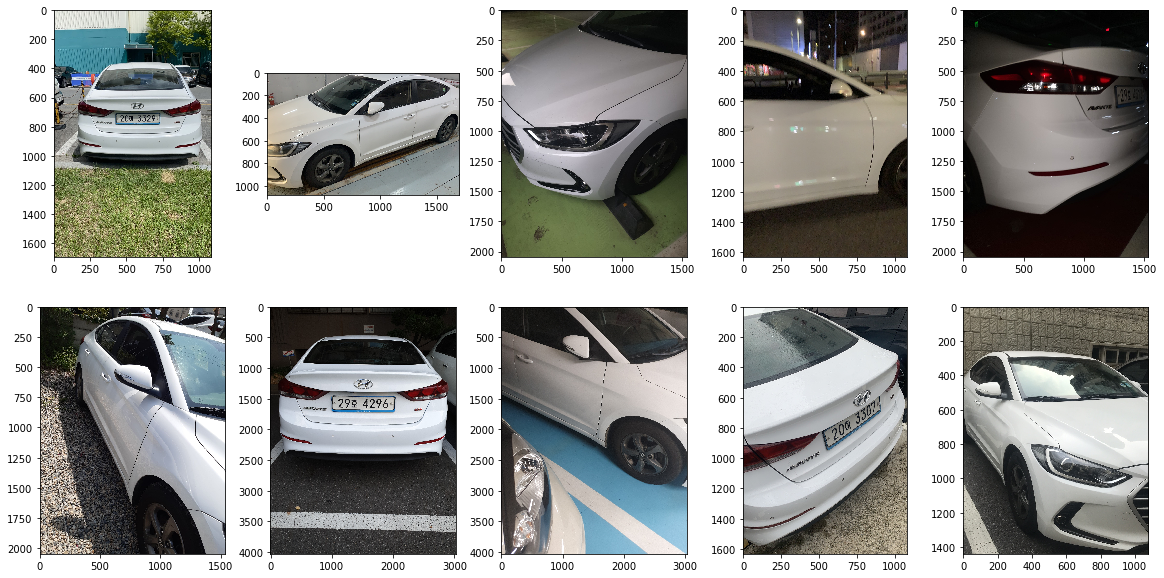

In [2]:
img_path = os.path.join(ROOT_DIR , 'ssl_dataset/socar_clustering/images/avante_images')
print('분석 대상 이미지들의 개수: ', len(os.listdir(img_path)))

fig = plt.figure(figsize=(20, 10))
columns = 5
rows = 2
for i in range(1, columns*rows +1):  # 샘플 10개 이미지만 골라서

    filename = os.listdir(img_path)[i]
    filepath = os.path.join(img_path, filename) # 파일 이름으로 읽고
    img = cv2.imread(filepath)[:,:,::-1] # 이미지로 읽은 후에 -> RGB 채널을 순서를 변경해주고

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)# 이미지를 plotting 합니다
plt.show()

In [5]:
sample_path = img_path + '/1.jpg' # path를 정의하고
sample_img = cv2.imread(sample_path) # opencv-python을 이용해서 이미지를 읽고

print(type(sample_img)) # nd.array 형태의
print(sample_img.shape) # height 1633 x width 1080 x channel 3 짜리 이미지가 나왔습니다

<class 'numpy.ndarray'>
(1699, 1080, 3)


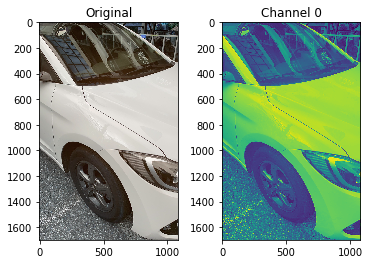

In [6]:
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(sample_img)

plt.subplot(1,2,2)
plt.title('Channel 0')
channel_img = sample_img[:,:,0] # 0번째 채널 이미지
plt.imshow(channel_img)

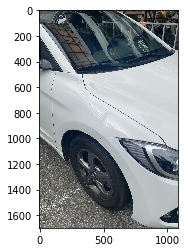

In [7]:
sample_img_rgb = sample_img[:,:,::-1] #모든 채널을 담은 이미지 
plt.imshow(sample_img_rgb)

In [8]:
from PIL import Image

img = Image.fromarray(np.uint8(sample_img_rgb))

In [9]:
def create_rotnet_set(base_dir, self_train_size, self_test_size):
    
    # Candidate Train, Test Filename 추출
    candidate_train_filenames, candidate_test_filenames = \
    path_to_train_test_filenames(base_dir, self_train_size, self_test_size)
    
    # Rotation 수행
    print('>> Start Making a Rotated Set...')
    save_base = os.path.join(base_dir, 'self_dataset', 'train_size_' + str(self_train_size))
    
    print('> Start Rotating Training Set...')
    train_save_dir = os.path.join(save_base, 'Training')
    if not os.path.exists(train_save_dir):
        os.makedirs(train_save_dir)
    rotate_and_save(candidate_train_filenames, train_save_dir)
        
    print('> Start Rotating Test Set...')
    test_save_dir = os.path.join(save_base, 'Test')
    if not os.path.exists(test_save_dir):
        os.makedirs(test_save_dir)
    rotate_and_save(candidate_test_filenames, test_save_dir)

In [10]:
def path_to_train_test_filenames(base_dir, self_train_size, self_test_size):
    candidate_train_filenames = list()
    candidate_test_filenames = list()
    
    # 각 Class 별로 파일 이름 모으고
    target_src_path = os.path.join(base_dir, 'images')
    print('>>>>>>', target_src_path)
    print(os.listdir(target_src_path))
    
    for class_name in sorted(os.listdir(target_src_path)):
        
        class_path = os.path.join(target_src_path, class_name)
        class_test_filenames = sorted(os.listdir(class_path))[:self_test_size]
        class_train_filenames = sorted(os.listdir(class_path))[self_test_size : self_test_size+self_train_size]
        
        for class_filename in class_test_filenames:
            class_filepath = os.path.join(class_path, class_filename)
            candidate_test_filenames.append(class_filepath)
        
        for class_filename in class_train_filenames:
            class_filepath = os.path.join(class_path, class_filename)
            candidate_train_filenames.append(class_filepath)
            
    print('Train for Self: ', len(candidate_train_filenames))            
    print('Test for Self: ', len(candidate_test_filenames))
    
    return candidate_train_filenames, candidate_test_filenames


In [13]:
def rotate_and_save(src_filenames, save_dir):
    rotation_list = [0, 90, 180, 270]
        
    for rotation_degree in rotation_list:
        print('> working on degree '+ str(rotation_degree))
        
        rot_save_dir = os.path.join(save_dir, 'degree_' + str(rotation_degree))
        if not os.path.exists(rot_save_dir):
            os.makedirs(rot_save_dir)

        for src_filename in src_filenames:

            img = cv2.imread(src_filename)
            rotated_img = image_rotator(img, rotation_degree)
    
            cv2.imwrite(os.path.join(rot_save_dir, src_filename.split('/')[-1]), rotated_img)

In [14]:
def image_rotator(img, rotate_type):
    
    if rotate_type == 0:
        rotated_img = img
    
    elif rotate_type == 90:
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    elif rotate_type == 180:
        rotated_img = cv2.rotate(img, cv2.ROTATE_180)
        
    elif rotate_type == 270:
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        
    else:
        raise ValueError

    return rotated_img

In [17]:
# Self Supervised Learning 학습을 위한 Training / Test Set 생성하기
self_dataset_path = ROOT_DIR+'/ssl_dataset/stanford_clustering/'
self_train_size = 1100
self_test_size = 346

create_rotnet_set(self_dataset_path, self_train_size, self_test_size)

>>>>>> /home/pung/repo/kimin-lab/ssl_dataset/stanford_clustering/images
['cars_images']
Train for Self:  1100
Test for Self:  346
>> Start Making a Rotated Set...
> Start Rotating Training Set...
> working on degree 0
> working on degree 90
> working on degree 180
> working on degree 270
> Start Rotating Test Set...
> working on degree 0
> working on degree 90
> working on degree 180
> working on degree 270


In [12]:
self_dataset_path = ROOT_DIR+'/ssl_dataset/stanford_clustering/'
self_train_size = 1100
self_test_size = 346

In [13]:
train_dir = self_dataset_path + '/self_dataset/train_size_'+str(self_train_size)+'/Training'
test_dir  = self_dataset_path + '/self_dataset/train_size_'+str(self_train_size)+'/Test'

data_transforms = transforms.Compose([
    transforms.Resize((512,512), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

train_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)
train_loaders = torch.utils.data.DataLoader(
    train_datasets,
    batch_size=32,
    shuffle=True,
)

test_datasets = datasets.ImageFolder(test_dir, transform=data_transforms)
test_loaders = torch.utils.data.DataLoader(
    test_datasets,
    shuffle=True,
)

dataloaders = {
    'train':train_loaders,
    'test':test_loaders
}

In [14]:
pretext_model = EfficientNet.from_name('efficientnet-b1', n_classes=5, pretrained=True)
pretext_model._fc = nn.Linear(1280, 4)
pretext_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretext_model.parameters(), lr=0.01)

In [15]:
num_epochs=25
model = pretext_model

train_acc_list =[]
train_loss_list = []
test_acc_list = []
test_loss_list = []


since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'test']:
        
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels)
            # print(labels.shape)
            # break
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        print('>> Phase: ', phase)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'train':
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
        else:
            test_acc_list.append(epoch_acc)
            test_loss_list.append(epoch_loss)
            
        # deep copy the model
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best test Acc: {:4f}'.format(best_acc))

# load best model weights
# model.load_state_dict(best_model_wts)

torch.save(best_model_wts , '../models/pretrained_effb1_orignal_socar_25.pt')

Epoch 0/24
--------------------
>> Phase:  train
train Loss: 1.0549 Acc: 0.6364
>> Phase:  test
test Loss: 0.6636 Acc: 0.7435
Epoch 1/24
--------------------
>> Phase:  train
train Loss: 0.6176 Acc: 0.7523
>> Phase:  test
test Loss: 0.4492 Acc: 0.7868
Epoch 2/24
--------------------
>> Phase:  train
train Loss: 0.4594 Acc: 0.7857
>> Phase:  test
test Loss: 0.3836 Acc: 0.8280
Epoch 3/24
--------------------
>> Phase:  train
train Loss: 0.3976 Acc: 0.8302
>> Phase:  test
test Loss: 0.3327 Acc: 0.8851
Epoch 4/24
--------------------
>> Phase:  train
train Loss: 0.3340 Acc: 0.8932
>> Phase:  test
test Loss: 0.2429 Acc: 0.9422
Epoch 5/24
--------------------
>> Phase:  train
train Loss: 0.2186 Acc: 0.9495
>> Phase:  test
test Loss: 0.1257 Acc: 0.9805
Epoch 6/24
--------------------
>> Phase:  train
train Loss: 0.1305 Acc: 0.9725
>> Phase:  test
test Loss: 0.0747 Acc: 0.9884
Epoch 7/24
--------------------
>> Phase:  train
train Loss: 0.0886 Acc: 0.9820
>> Phase:  test
test Loss: 0.0519 Acc:

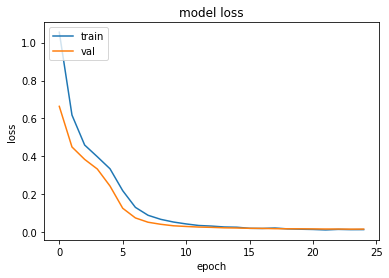

In [16]:
from matplotlib import pyplot as plt
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

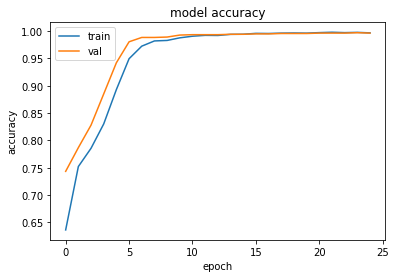

In [17]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()